# Anomaly Detection in ECG data

This notebook provides tasks to identify anomalies in an ECG data set. Download the dataset from the lab google drive.

Required Python packages: pandas, numpy, matplotlib, pytorch

## Task 1: Load an visualize the data

Download the csv from the link provided above and load it into a pandas dataframe. Visualize the data of normal (label 1) vs abnormal (label 0) ECG signals. 

What are the differences for both? Visualize an average normal and abnormal ECG (with standart derivations).

In [33]:
import pandas as pd

dataframe = pd.read_csv(
    "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", header=None
)
raw_data = dataframe.values

In [34]:
label = raw_data[:,-1]
normal_data = raw_data[label == 0][:,:-1]
anomaly_data = raw_data[label == 1][:,:-1]
print(raw_data.shape, normal_data.shape, anomaly_data.shape, label.shape)

(4998, 141) (2079, 140) (2919, 140) (4998,)


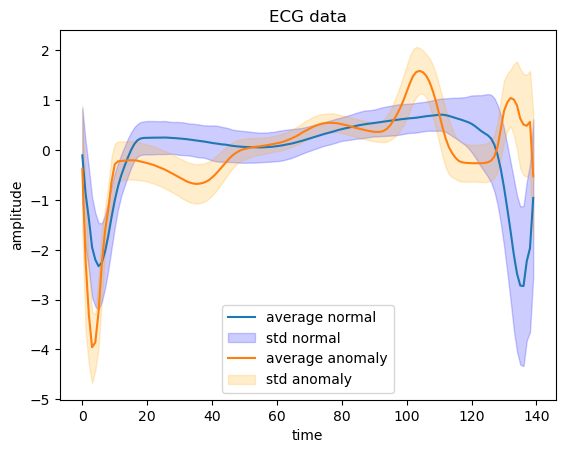

In [35]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.mean(normal_data, axis=0), label="average normal")
plt.fill_between(x = range(len(np.mean(normal_data, axis=0))), 
                 y1 = np.mean(normal_data, axis=0) + np.std(normal_data, axis=0), 
                 y2 = np.mean(normal_data, axis=0) - np.std(normal_data, axis=0), 
                 alpha=0.2,
                 color="blue",
                 label="std normal")
plt.plot(np.mean(anomaly_data, axis=0), label="average anomaly")
plt.fill_between(x = range(len(np.mean(anomaly_data, axis=0))), 
                 y1 = np.mean(anomaly_data, axis=0) + np.std(anomaly_data, axis=0), 
                 y2 = np.mean(anomaly_data, axis=0) - np.std(anomaly_data, axis=0), 
                 alpha=0.2,
                 color="orange",
                 label="std anomaly")
plt.title("ECG data")
plt.xlabel("time")
plt.ylabel("amplitude")
plt.legend()
plt.show()

## Task 2: Train a Autoencoder for normal (training data)

Split your data into a (stratified) 80/20 split. Use the normal records of your train data to fit an Autoencoder model. You may use Optuna to find the optimal parametrization of your model.

Visulaize the training/test loss of your model.


In [36]:
import optuna
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Preprocess Data

In [37]:
y = raw_data[:, -1]
X = raw_data[:, :-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42934, stratify=y)

print(f'Mean of training labels: {train_labels.mean()}, mean of test labels: {test_labels.mean()}')

Mean of training labels: 0.5840420210105053, mean of test labels: 0.584


In [38]:
# For Task 3 we normalize the training data and use the scaler for test data as well
scaler_all = MinMaxScaler()
train_data = scaler_all.fit_transform(train_data)
test_data = scaler_all.transform(test_data)

In [39]:
# For Task 2 we only need the normal data in the training set
train_data_norm = train_data[train_labels == 1]

## Load Data in Dataset and DataLoader

In [40]:
from torch.utils.data import Dataset, DataLoader

In [41]:
class ECGDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

## Autoencoder model

In [42]:
class AE(nn.Module):
    def __init__(self, input_dim=139):
        super(AE, self).__init__()
        # Define the architecture
        # The Encoder part has to compress the input data (139) to a latent space representation (16)
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        # The Decoder part has to reconstruct the input data (139) from the latent space representation (16)
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid(),  # Use Sigmoid to ensure output is between 0 and 1
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out

## Train AE Model

In [43]:
# Load Data (only normal data for training)
train_dataset = ECGDataset(train_data_norm)
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load Model
input_dim = train_dataset.data.shape[1]
ae_model = AE(input_dim=input_dim)

In [44]:
# Add Loss and Optimizer
loss = nn.L1Loss()
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)

In [45]:
EPOCHS = 200
training_losses = []
for epoch in range(EPOCHS):
    ae_model.train()
    total_loss = 0
    for x in train_data_loader:
        optimizer.zero_grad()
        reconstructed = ae_model(x)
        l = loss(reconstructed, x)
        l.backward()
        optimizer.step()
        total_loss += l.item() * x.size(0)
    total_loss /= len(train_data_loader.dataset)
    training_losses.append(total_loss)

    #print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_data_loader)}")

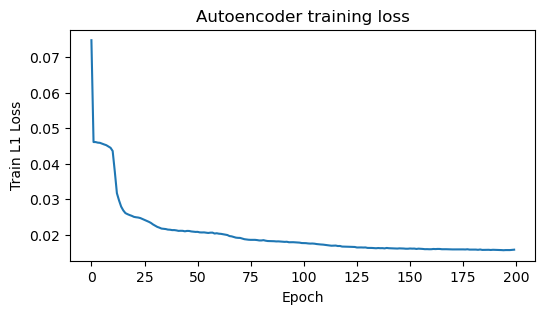

In [49]:
# Plot training loss
plt.figure(figsize=(6,3))
plt.plot(training_losses)
plt.xlabel("Epoch"); plt.ylabel("Train L1 Loss"); plt.title("Autoencoder training loss")
plt.show()

## Evaluate Model

In [54]:
# Load train data for normal and abnormal
train_dataset_norm = ECGDataset(train_data_norm)
train_dataset_anorm = ECGDataset(train_data[train_labels == 0])

In [55]:
ae_model.eval()

err_normal = torch.mean(torch.abs(ae_model(train_dataset.data) - train_dataset.data), dim=1)  # mean across features
err_abnormal = torch.mean(torch.abs(ae_model(train_dataset_anorm.data) - train_dataset_anorm.data), dim=1)  # mean across features

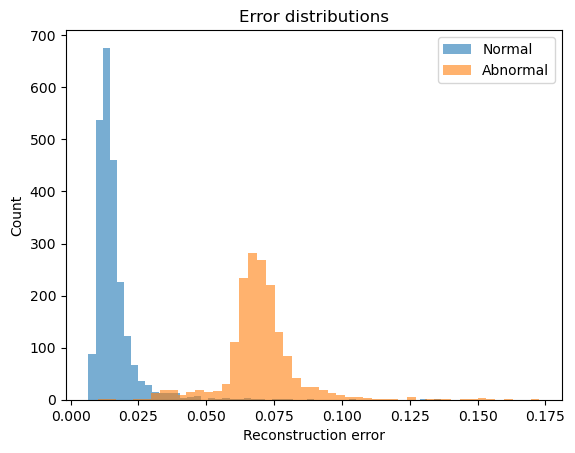

In [56]:
plt.hist(err_normal.detach().numpy(), bins=50, alpha=0.6, label='Normal')
plt.hist(err_abnormal.detach().numpy(), bins=50, alpha=0.6, label='Abnormal')
plt.xlabel("Reconstruction error"); plt.ylabel("Count"); plt.legend(); plt.title("Error distributions")
plt.show()

## Task 3: Treshold your test data & evaluate your model

For any single normal and abnormal test data point, plot the time series, the decoded autoencoder reconstruction and the error as the area between these 2 plots. Compute the absolute error as the absolute of the integral of both graphs.

Plot a histogram of the training/test loss and - based on your findings - generate a treshold to differentiate between normal/anormal test data samples. Based on your predictions, report the performance of your model. 


